# PySpark - Machine Learning with ML Module

## Introduction

In the previous Project 4, the topics covered were from the MLlib Module, however this has be deprecated recently. Therefore in this project 5, the currently support machine learning module will be explored and is called the ML module. Similar to the MLlib, this ML module consists of a wide variety of machine learning models, with the exception that it operates on Spark DataFrames. This also means that it can leverage the tungsten execution optimisations. 

## Breakdown of this Notebook

- Transformers introduction
- Estimators introduction
- Pipelines introduction
- Selecting the most predictable features
- Predicting forest coverage types
- Estimating forest elevations
- Clustering forest cover types
- Tuning Hyperparameters
- Extracting features from text
- Discretising conitnuous variables
- Standardising continuous variables
- Topic Mining

## Dataset:

The dataset used for this project is the forest cover type dataset. It is used to predict the forest cover type from cartographic variables, meaning that there is no remote sensed data. The forest area included in this dataset are the four wilderness areas (Rawah (area 1), Neota (area 2), Comanche Peak (area 3), Cache la Poudre (area 4)) that is located in Roosevelt National Forest of Northern Colorado.

Source: https://archive.ics.uci.edu/ml/datasets/covertype or https://www.kaggle.com/uciml/forest-cover-type-dataset


## 1 PySpark Machine Configuration:

Here it only uses 4 processing cores from the CPU, and it set up by the following code.

In [1]:
%%configure
{
    "executorCores" : 4
}

In [2]:
from pyspark.sql.types import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2 Setup the Correct Directory:

In [3]:
import os

# Change the Path:
path = '++++your working directory here++++/Datasets/'
os.chdir(path)
folder_pathway = os.getcwd()

# print(folder_pathway)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3 Load in the Dataset:

There should be a folder called "Datasets" included for the CSV file.

In [4]:
forest_dat = spark.read.csv(folder_pathway + '/Datasets/forest_covtype.csv', header = True, inferSchema = True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
forest_dat.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area1: integer (nullable = true)
 |-- Wilderness_Area2: integer (nullable = true)
 |-- Wilderness_Area3: integer (nullable = true)
 |-- Wilderness_Area4: integer (nullable = true)
 |-- Soil_Type1: integer (nullable = true)
 |-- Soil_Type2: integer (nullable = true)
 |-- Soil_Type3: integer (nullable = true)
 |-- Soil_Type4: integer (nullable = true)
 |-- Soil_Type5: integer (nullable = true)
 |-- Soil_Type6: integer (nullable = true)
 |-- Soil_Type7: integer

## 4 Transformers introduction:

A Transformer performs a transform() method that converts one DataFrame into another, usually appending a single or more columns. It is also an abstraction that includes feature transformaers and learned models.

- A feature transformer will take a DataFrame, read a column (like text), and then map it into a new column (feature vectors), once done, it will output a new DataFrame with the mapped column appended.

- A learning model will take a DataFrame, read the feature vectors column, predict the label for each feature vector, and then it will output a new DataFrame with predicted label results appended as a column.

Source: https://spark.apache.org/docs/1.6.0/ml-guide.html#transformers and https://spark.apache.org/docs/1.6.0/ml-features.html

### The following diagram shows a list of other types of Transformers that is able to convert one feature to another:

Image source -> https://spark.apache.org/docs/2.2.0/ml-features.html


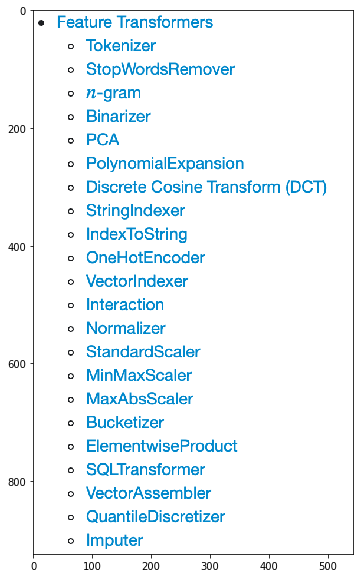

In [6]:
%%local

# Import the required library and set to use ggplot:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

folder_pathway = os.getcwd()
# print(folder_pathway)
image_path = folder_pathway + "/Description Images/"

# plot the image
fig, ax1 = plt.subplots(figsize=(16,10))
image = mpimg.imread(image_path + 'Spark Transformer types.png')
plt.imshow(image);

print('Image source -> https://spark.apache.org/docs/2.2.0/ml-features.html')

### In this section, the Bucketizer and VectorAssembler will be explored.

## 4.1 Bucketiser:

This will transform the "Horizontal_Distance_To_Hydrology" column into 10 equidistant buckets. The Horizontal_Distance_To_Hydrology column is quantitative, measured in meters and can be described as the __Horizontal Distance to nearest surface water features__.

Bucketizer uses a list of thresholds to transform a continuous numerical variable into a discrete one (with as many levels as the length of the list of thresholds plus one).

To do this:
- First, load in the required packages.
- Next, bucketise the numerical variables into 10 buckets.
- Calculate the minimum and maximum values for the "Horizontal_Distance_To_Hydrology" feature and it will return these 2 values to the driver node. 
- When on the driver, a list of thresholds is created that takes in 3 parameters. The first parameter is np.arrange() is the minimum, the second is the maximum and the last one is the size of each step. This should define the "splits" list.
- Pass the splits list to the .Bucketizer() method. 
- Lastly, the bucketizer object will transform the DataFrame accordingly.

In [7]:
# Import the required package:
import pyspark.sql.functions as f
import pyspark.ml.feature as feat
import numpy as np

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Define the number of numerical variables to bucketise:
buckets_nb = 10

# Calculate the min and max values of "Horizontal_Distance_To_Hydrology" feature:
dist_minMax = (
    forest_dat.agg(
        f.min('Horizontal_Distance_To_Hydrology').alias('min'),
        f.max('Horizontal_Distance_To_Hydrology').alias('max')
    )
    .rdd
    .map(lambda row: (row.min, row.max))
    .collect()[0]
)

# Calc the range between max and min distance:
rng_dist = dist_minMax[1] - dist_minMax[0]

# Create a Splits Lists:
splits_list = list(np.arange(
    dist_minMax[0],
    dist_minMax[1],
    rng_dist / (buckets_nb + 1)
))

# Using the Split list for the Bucketiser method:
bucketiser = feat.Bucketizer(
    splits = splits_list,
    inputCol = 'Horizontal_Distance_To_Hydrology',
    outputCol = 'Horizontal_Distance_To_Hydrology_Bkt'
)

# Transform the DataFrame:
(
    bucketiser
    .transform(forest_dat)
    .select('Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology_Bkt')
    .show(5)
)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------+------------------------------------+
|Horizontal_Distance_To_Hydrology|Horizontal_Distance_To_Hydrology_Bkt|
+--------------------------------+------------------------------------+
|                             258|                                 2.0|
|                             212|                                 1.0|
|                             268|                                 2.0|
|                             242|                                 1.0|
|                             153|                                 1.0|
+--------------------------------+------------------------------------+
only showing top 5 rows

## 4.2 VectorAssembler:

This section will combine multiple columns into a single column, then be used for PCA to find the principal components from the dataset. This will reduce the dimensionality/complexity as well.

The VectorAssembler collates multiple columns of features into a single column or in other words, it combines the specified (separate) features into a single feature. Unlike other Transformers, it has the inputCols (with an "s") parameter that accepts a list of columns rather than a single column.

To do this:
- Use the .VectorAssembler() to collate all of the columns from the dataFrame.
- Extract the top 5 most significatn principal components by using the "feat" column ( new a SparseVector containing all the features) in the PCA() method.

In [9]:
# Instantise the VectorAssembler and input the dataset for collation of the columns:
vectorAssembler = (
    feat.VectorAssembler(inputCols = forest_dat.columns, outputCol = 'feat')
)

# Perform PCA:
nb_PC = 5

pca_dat = (
    feat.PCA(k = nb_PC, inputCol = vectorAssembler.getOutputCol(), outputCol = 'pca_feat')
)

# Fit and transfrom the dataset with the calculated PCA mapping:
(
    pca_dat
    .fit(vectorAssembler.transform(forest_dat))
    .transform(vectorAssembler.transform(forest_dat))
    .select('feat', 'pca_feat')
    .take(1)
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(feat=SparseVector(55, {0: 2596.0, 1: 51.0, 2: 3.0, 3: 258.0, 5: 510.0, 6: 221.0, 7: 232.0, 8: 148.0, 9: 6279.0, 10: 1.0, 42: 1.0, 54: 5.0}), pca_feat=DenseVector([-3887.7711, 4996.8103, 2323.0932, 1014.5873, -135.1702]))]

## 5 Estimators introduction:

Estimators can be described as an abstraction of a learning algorithm (or any algorithm) that will fit/train on the dataset. More specifically, an Estimator that implements a fit() method that accepts a DataFrame to produce a Model. This Model is a Transformer. For example, for Logistic Regression where it is an Estimator and that calling fit() method will train the LogisticRegressionModel, where it is a Model and hence a Transformer.

Source: https://spark.apache.org/docs/1.6.0/ml-guide.html#estimators, https://spark.apache.org/docs/1.6.0/ml-classification-regression.html and https://spark.apache.org/docs/1.6.0/ml-clustering.html


### The following diagrams shows a list of other types of Estimators (Machine Learning Models):

#### For Classification and Regression models:

Image source -> https://spark.apache.org/docs/1.6.0/ml-classification-regression.html


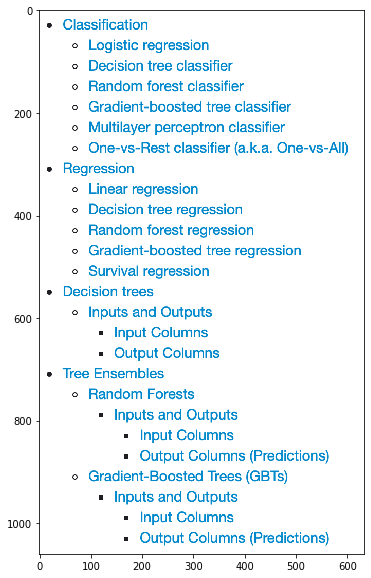

In [10]:
%%local

# plot the image
fig, ax1 = plt.subplots(figsize=(16, 10))
image = mpimg.imread(image_path + 'Spark Estimator types_1.png')
plt.imshow(image);

print('Image source -> https://spark.apache.org/docs/1.6.0/ml-classification-regression.html')

#### For Clustering models:

Image source -> https://spark.apache.org/docs/1.6.0/ml-clustering.html


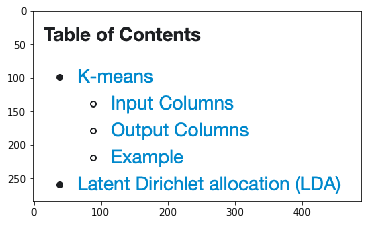

In [11]:
%%local

# plot the image
fig, ax1 = plt.subplots(figsize=(16, 3.5))
image = mpimg.imread(image_path + 'Spark Estimator types_2.png')
plt.imshow(image);

print('Image source -> https://spark.apache.org/docs/1.6.0/ml-clustering.html')

## 5.1 Estimator Type: Support Vector Machine (SVM)

This section will explore on building a SVM model.

To do this:
- First, load in the necessary libraries.
- Next, use the .VectorAssembler() method to extract all the columns from the dataFrame, except for the last column that is the "CoverType" which will be the __Label__.
    - The label here is the "Spruce-fir" type which is equal to 1 in the dataset. 
    - To find these values, check whether the "Cover_Type" == 1 and casting the resulting Boolean as an Integer.
- Next, select the label and features.
- Next, create a LinearSVC object for the SVM model.
    - Specify the max iterations as 10,
    - Set it to have L2 (or Ridge) regularisation and to be 1%.
- Finally, use the .fit() method the SVM object on the dataset, and once completed, extract the estimated coefficients.

Other parameters can be:
- featuresCol, set as the name of the feature columns -> Default is "features"
- labelCol, set as the name of the label column
- predictionCol, set as the name of the prediction column, if there is a need to rename it to something else other than "prediction".
- tol, stopping parameter defining the minimum change between iterations in terms of the cost function. -> Default is "10^-6", if it is changed to a smaller value then it will be assumed to have converged.
- rawPredictionCol, returns the raw value from the generating function.
- fitIntercept, the model will fit the intercept as well -> Default is set to True.
- standardization, it standardises the features prior to fitting the model -> Default is set to True
- threshold, it decided what will be classified into either 1 or 0 -> Default is "0.0"
- weightCol, Each observation's column (set as Column names) will be weighted differently.
- aggregationDepth, this would be the tree-depth parameter used for the aggregation.

In [12]:
# Import the relevant libraries:
import pyspark.ml.classification as cl

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Collate the set of columns into a single feature column:
vectorAssembler = feat.VectorAssembler(
    inputCols = forest_dat.columns[0:-1],
    outputCol = 'features'
)

# Select only the Spruce-fir type to be the labels:
Spruce_fir_dat = (
    vectorAssembler
    .transform(forest_dat)
    .withColumn('label', (f.col('Cover_Type') == 1).cast('Integer') )
    .select('label', 'features')
)

# Instantise the SVM object:
svc_obj= cl.LinearSVC(maxIter = 10, regParam = 0.01)

# Fit the model to the dataset:
svc_model = svc_obj.fit(Spruce_fir_dat)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Extract the estimated coefficients from the model:
svc_model.coefficients

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([-0.0001, -0.0, -0.0023, -0.0, -0.0001, 0.0, -0.001, -0.0017, -0.0003, -0.0, 0.0, 0.0401, -0.0071, -0.0958, -0.0901, -0.0653, -0.0655, -0.0437, -0.0928, -0.0848, -0.0211, -0.0045, -0.0498, -0.0829, -0.0522, -0.0325, -0.0263, -0.0923, -0.0889, -0.0275, -0.0606, -0.0595, 0.0341, -0.003, 0.0822, 0.0607, 0.0351, 0.0093, 0.0048, -0.0154, 0.0422, -0.0673, -0.0039, -0.0142, 0.0036, 0.0078, 0.0, -0.0117, 0.0283, -0.0002, -0.0463, 0.0394, 0.0292, 0.0358])

## 5.2 Estimator Type: Linear Regression

This section will explore on building a Linear Regression model. It has a similar set up to the above SVM model, however the Label used here is different. The Label chosen is the "Elevation" column and it will be cast as Float (for regression problems).

In [15]:
# Import the required Libraries:
import pyspark.ml.regression as rg

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Collate the set of columns into a single feature column:
vectorAssembler = feat.VectorAssembler(
    inputCols = forest_dat.columns[1:],
    outputCol = 'features'
)

# Select only the label to be "Elevations":
elevation_dat = (
    vectorAssembler
    .transform(forest_dat)
    .withColumn('label', f.col('Elevation').cast('Float') )
    .select('label', 'features')
)

# Instantise the SVM object:
lr_obj= rg.LinearRegression( maxIter = 10, regParam = 0.01, elasticNetParam = 1.00 )

# Fit the model to the dataset:
lr_model = lr_obj.fit(elevation_dat)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Extract the estimated coefficients from the model:
lr_model.coefficients

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([0.0309, 0.6522, 0.1911, 0.1424, 0.0342, 0.7402, 1.053, -0.0017, -0.0041, 2.7163, 189.0362, 27.8238, -265.8505, -407.4379, -346.0612, -364.3841, -302.6788, -400.5852, -212.9918, -126.1329, -117.7423, -312.0478, -248.7118, -221.4788, -155.1459, -84.5129, -398.0433, -387.8102, -179.4485, -261.3875, -337.7875, 48.0629, -94.7813, 149.8043, 135.144, 80.0901, 64.3659, 124.0233, -115.0126, 119.1285, -181.7498, 10.8056, -42.7849, 65.5441, 102.2562, 36.9865, -48.1163, 379.2091, 256.0169, 497.1714, 313.0607, 337.172, 397.0758, -14.4551])

### This Linear Regression model also calculates the summary which returns the basic performance statistics:

In [18]:
summary_lr = lr_model.summary

print(
    ' R-Squared: ' + str(round(summary_lr.r2, 4)) + '\n',
    'RMSE: ' + str(round(summary_lr.rootMeanSquaredError, 4)) + '\n',
    'MAE: ' + str(round(summary_lr.meanAbsoluteError, 4))
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

 R-Squared: 0.786
 RMSE: 129.5087
 MAE: 103.3408

### Observation:

By examining the R-Squared value of 78%, it indicates that 78% of all the variability of the data is around its mean meaning that the model is quite well fitted to the data. R-squared is a measure of how close the data are to the fitted regression line.

Source: https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

## 6 Pipelines Introduction:

A ML project would typically consists of several steps such as data preprocessing, feature extractions, fitting/training the model and evaluation of the results. Throughout these steps, a lot of transformations were performed on the data in sequence. For this, the Pipeline class can be very helpful to sequence each execution steps (stages) that would lead to an estimated model. It is able to chain multiple Transformers and Estimators forming a sequencial execution workflow. This will make the code more readable, debuggable and maintainable as it provides a higher abstraction of the overall system. It also helps to avoid explicitly create multiple transformed datasets as the data goes through different parts of the process.

Source: https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/



### The diagram below shows an example of a Pipeline:

Image source -> https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/


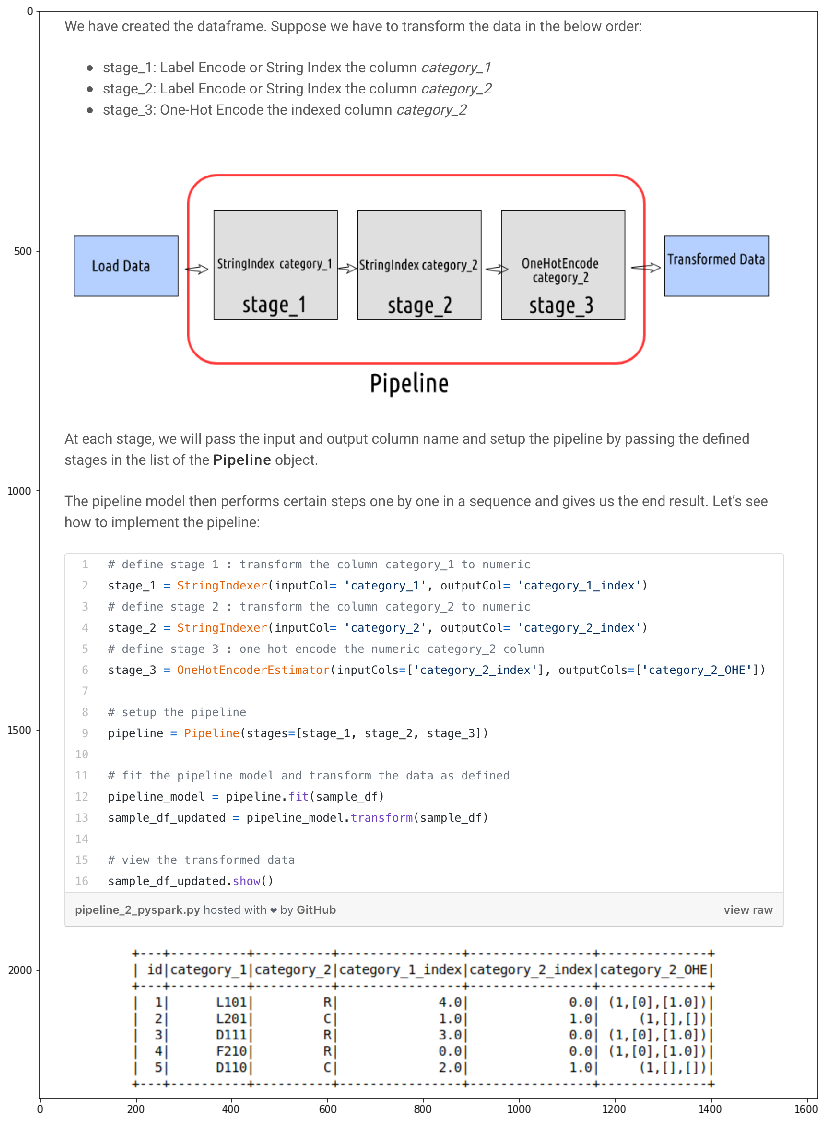

In [19]:
%%local

# plot the image
fig, ax1 = plt.subplots(figsize=(16, 20))
image = mpimg.imread(image_path + 'Pipeline Example.png')
plt.imshow(image);

print('Image source -> https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/')

## 6.1 Pipeline implementation:

This section will show how to streamline the execution of a generalised linear regression model (GLM)

To do this:
- First, import the Pipeline package.
- Create a VectorAssembler object to collate the dataset columns.
- Create a GLM object and set the parameters.
- Place each of these objects into the Pipeline and run it.
- Lastly, fit and transform the dataset with the pipeline object and use the " .show() " method to preview the results.

After fitting the model to the data, plot the distribution:
- Select the "Elevation" column from the transformed dataset.
- Convert it to a Pandas format with the " .toPandas() " so that it can be plotted as a histogram.


### However, before the prediction can be done, Ddo Step 6.2 first:
 
In the GLM object for prediction code block, there are __two parameters__ called "link" and "family" to specify. \

The __"link" parameter__ is function that transform the probabilities of the levels of categorical response variable into a scontinuous scale which is unbounded. This ensures that the relationship between the predictors and reponse can be modeled as a linear regression problem. \

The __"family" parameter__ is to select the kind of of the error distribution to be used in the model. The supported options: "gaussian", "binomial", "poisson", "gamma" and "tweedie". Default is "gaussian".

#### To decide for both Parameters, plot the distribution of the Elevation, as seen below.

For more information:
- https://online.stat.psu.edu/stat504/node/216/
- http://web.pdx.edu/~newsomj/cdaclass/ho_glm.pdf
- https://support.minitab.com/en-us/minitab/19/help-and-how-to/modeling-statistics/regression/supporting-topics/logistic-regression/link-function/
- https://spark.rstudio.com/reference/ml_generalized_linear_regression/

## 6.2 Plot the distribution of the Elevation:

In [20]:
# Import the required package:
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# Select the Elevation column:
transformed_df = forest_dat.select('Elevation')

# Convert to Pandas format:
transformed_df.toPandas().hist()

# Save the plot:
folder_pathway = os.getcwd()
# print(folder_pathway)
image_path = folder_pathway + "/Description Images/"

plt.savefig(image_path + 'Elevation Histogram.png')
plt.close('all')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

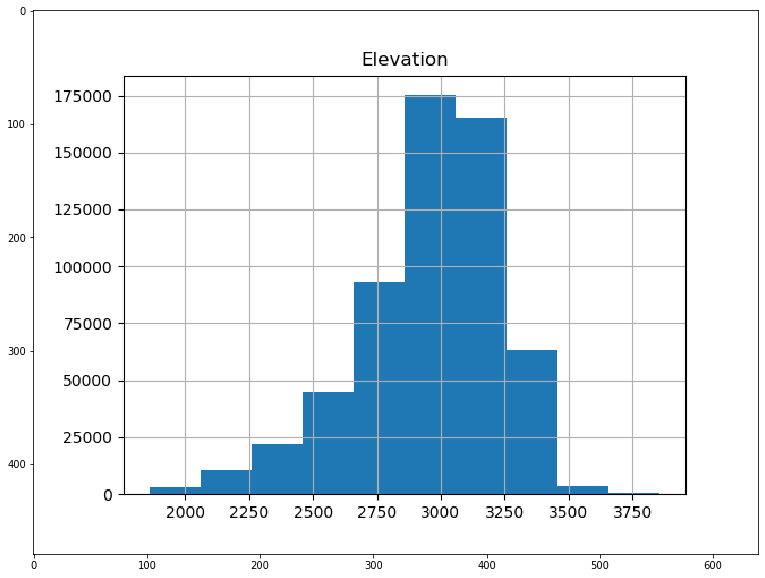

In [22]:
%%local

# plot the image
fig, ax1 = plt.subplots(figsize=(16, 10))
image = mpimg.imread(image_path + 'Elevation Histogram.png')
plt.imshow(image);

### Observation:

From the chart above, it can be seen that the distribution is slight skewed to the left (negative skewness). However, it can still be assumed to follow a normal distribution and therefore the two parameters can be set as:
- family = 'gaussian' (which is the default setting)
- link = 'identity'

source: https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/skewed-distribution/

## 6.1 (Continue) Pipeline implementation:

In [23]:
# Import the Libraries:
from pyspark.ml import Pipeline

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# Collate all the feature columns into a single column:
vectorAssembler = feat.VectorAssembler(
    inputCols = forest_dat.columns[1:],
    outputCol = 'features'
)

# Create the GLM model:
lr_obj = rg.GeneralizedLinearRegression(
    labelCol = 'Elevation',
    maxIter = 10,
    regParam = 0.01,
    link = 'identity',
    linkPredictionCol = 'p'
)

# Create a Pipeline:
pipeline_set = Pipeline(stages = [vectorAssembler, lr_obj])

# Fit and Transform the data, select the Elevation and prediction column then print out the results:
(
    pipeline_set
    .fit(forest_dat)
    .transform(forest_dat)
    .select('Elevation', 'prediction')
    .show(5)
)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------------------+
|Elevation|        prediction|
+---------+------------------+
|     2596|2840.7801831411316|
|     2590|2828.7464246669683|
|     2804| 2842.761272955131|
|     2785| 2966.057500325109|
|     2595|2817.1687155114637|
+---------+------------------+
only showing top 5 rows

### Observation:

From the results above, it can be seen that the prediction of elevation values are close to the actual values.

## 7 Selecting the most Predictable Features from the dataset:

This section will cover how to select the best predicting model during the process of building either a classification or regression prediction model.

Utilising all the features from the data to build the model can results in a highly complex model that would be prone to overfitting. It may have collinearity problems where other variables would explain the same portion of variance, or that if one of the variable is missing and this would result in an errorneous output.

## 7.1 Select the Top 10 Features:

The idea is to choose the top 10 features that would results in the greatest predictive power for the model.

To do this:
- Collate all the feature columns into a single column (single vector), without using the label column (Cover_Type).
- Next, use the .ChiSqSelector() function to find and select the best features based on pariwise chi-squaared test between the each of the features and the target variable.

In [25]:
# Collate the columns to a single column:
vectorAsssembler = feat.VectorAssembler(
    inputCols = forest_dat.columns[0:-1],
    outputCol = 'features'
)

# Select the best features:
selected_features = feat.ChiSqSelector(
    labelCol = 'Cover_Type',
    numTopFeatures = 10,
    outputCol = 'selected'
)

# Pipeline:
pipeline_selectedFeatures = Pipeline(stages = [vectorAsssembler, selected_features])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Inspect the results:
(
    pipeline_selectedFeatures
    .fit(forest_dat)
    .transform(forest_dat)
    .select(selected_features.getOutputCol())
    .show(6)
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            selected|
+--------------------+
|(10,[0,1,2,3,5,6,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
+--------------------+
only showing top 6 rows

### Observation:

The resulting SparseVector has a length of 10 and that it consists of the top 10 most predictable features.

## 7.3 Correlation Matrix:

For regression problems, it is advisable to choose a different method than the .ChiSqSelector() to find the the top features against continuous targets. Therefore, the approach taken would be to check for __correlations__ between every feature. This will then be used to select the most highly correlated features with the target, but these features should not be correlated with each other.

To do this:
- First, is to collate the columns.
- Pass the dataFrame into the Correlation class by using the Transformer. There are 3 parameters here, the first one is the data, the second one is the 'features' column, and the third one is the type of correlation that is set to 'pearson'.

In [27]:
# Import the required library:
import pyspark.ml.stat as st

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# Collate the columns into a single column of features:
features_n_label = feat.VectorAssembler(
    inputCols = forest_dat.columns,
    outputCol = 'features'
)

# Find the correlations:
corr = st.Correlation.corr(
    features_n_label
    .transform(forest_dat),
    'features',
    'pearson'
)

# Inspect:
print(str(corr.collect()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(pearson(features)=DenseMatrix(55, 55, [1.0, 0.0157, -0.2427, 0.3062, 0.0933, 0.3656, 0.1122, 0.2059, ..., 0.0046, 0.0803, 0.0254, 0.0803, 0.1602, 0.1557, 0.1284, 1.0], False))]

In [29]:
# Inspect:
print(str(corr.collect()[0][0]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseMatrix([[ 1.        ,  0.01573494, -0.24269664, ...,  0.19359464,
               0.21261232, -0.26955378],
             [ 0.01573494,  1.        ,  0.07872841, ...,  0.00829428,
              -0.00586558,  0.0170798 ],
             [-0.24269664,  0.07872841,  1.        , ...,  0.09360193,
               0.02563691,  0.14828541],
             ...,
             [ 0.19359464,  0.00829428,  0.09360193, ...,  1.        ,
              -0.01929168,  0.15566826],
             [ 0.21261232, -0.00586558,  0.02563691, ..., -0.01929168,
               1.        ,  0.1283513 ],
             [-0.26955378,  0.0170798 ,  0.14828541, ...,  0.15566826,
               0.1283513 ,  1.        ]])

### With the above Correlation Matrix, it is now possible to extract the top 10 most correlated features with the label: FOR ELEVATION (Continuous), NOT COVER TYPE (Discrete).

To do this:
- First, set the number of features to extract, where it will create a dictionary with all the columns from the data.
- Next, select the first column which is the target ('Elevation' feature) from the correlation matrix. Convert it from a DenseMatrix to a NumPy array with the .toArray() method. The index to the elements of this array is also appended, as it informs which element is most correlated to the target variable.
- Next, sort the list in descending order in terms of the absolute values of the correlation coefficients.
- Next, loop through the top 10 elements of the list and select the column (from the cols dictionary) that corresponds with the selected index.
- Print out the results.

For more information on "np.ndenumerate": https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndenumerate.html

In [30]:
# Set the number of features:
nb_features = 10

# Create a dictionary for the columns: key (i) is the number of the column, and value (e) is the name of the column.
cols = dict([
    (i, e) for i, e in enumerate(forest_dat.columns)
    ])

# Extract the correlation matrix:
corr_mat = corr.collect()[0][0]

# Label the correlation matrix with index:
label_corr_with_idx = [
    (i[0], e) for i, e in np.ndenumerate(corr_mat.toArray()[:,0])   
][1:]

# Sort the list:
label_corr_with_idx_sorted = sorted( label_corr_with_idx, key = lambda el: -abs(el[1]) )

# Select only the top 10 features:
features_selected = np.array([
    cols[el[0]] for el in label_corr_with_idx_sorted    
])[0:nb_features]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Let's inspect each part of the code:

In [31]:
cols

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0: 'Elevation', 1: 'Aspect', 2: 'Slope', 3: 'Horizontal_Distance_To_Hydrology', 4: 'Vertical_Distance_To_Hydrology', 5: 'Horizontal_Distance_To_Roadways', 6: 'Hillshade_9am', 7: 'Hillshade_Noon', 8: 'Hillshade_3pm', 9: 'Horizontal_Distance_To_Fire_Points', 10: 'Wilderness_Area1', 11: 'Wilderness_Area2', 12: 'Wilderness_Area3', 13: 'Wilderness_Area4', 14: 'Soil_Type1', 15: 'Soil_Type2', 16: 'Soil_Type3', 17: 'Soil_Type4', 18: 'Soil_Type5', 19: 'Soil_Type6', 20: 'Soil_Type7', 21: 'Soil_Type8', 22: 'Soil_Type9', 23: 'Soil_Type10', 24: 'Soil_Type11', 25: 'Soil_Type12', 26: 'Soil_Type13', 27: 'Soil_Type14', 28: 'Soil_Type15', 29: 'Soil_Type16', 30: 'Soil_Type17', 31: 'Soil_Type18', 32: 'Soil_Type19', 33: 'Soil_Type20', 34: 'Soil_Type21', 35: 'Soil_Type22', 36: 'Soil_Type23', 37: 'Soil_Type24', 38: 'Soil_Type25', 39: 'Soil_Type26', 40: 'Soil_Type27', 41: 'Soil_Type28', 42: 'Soil_Type29', 43: 'Soil_Type30', 44: 'Soil_Type31', 45: 'Soil_Type32', 46: 'Soil_Type33', 47: 'Soil_Type34', 48: 'Soil

In [32]:
corr_mat

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseMatrix(55, 55, [1.0, 0.0157, -0.2427, 0.3062, 0.0933, 0.3656, 0.1122, 0.2059, ..., 0.0046, 0.0803, 0.0254, 0.0803, 0.1602, 0.1557, 0.1284, 1.0], False)

In [33]:
label_corr_with_idx

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(1, 0.01573493829041497), (2, -0.2426966393141449), (3, 0.30622893934768924), (4, 0.09330643500380469), (5, 0.36555927531252375), (6, 0.1121793041169593), (7, 0.20588691351871527), (8, 0.05914777781607197), (9, 0.14802156018835516), (10, 0.13183762021052192), (11, 0.23816355973517817), (12, 0.06655009338231924), (13, -0.6193739227941123), (14, -0.20451180949907208), (15, -0.1876765133745695), (16, -0.18246332703926604), (17, -0.18352088612288195), (18, -0.15037632288675432), (19, -0.21460630519757465), (20, -0.0022515383870956042), (21, -0.0030205903557226346), (22, -0.060915169933591085), (23, -0.42874573436438096), (24, -0.13422660464765226), (25, -0.11890455195298559), (26, -0.04398427260061098), (27, -0.08082502997338305), (28, -0.007153048451369679), (29, -0.05944628333685027), (30, -0.11102797462726256), (31, -0.08181069833846362), (32, 0.033144348009875), (33, -0.04312848360452678), (34, 0.01755745734673338), (35, 0.15895894470649016), (36, 0.12435646789180124), (37, 0.05358174

In [34]:
label_corr_with_idx_sorted

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(13, -0.6193739227941123), (23, -0.42874573436438096), (5, 0.36555927531252375), (3, 0.30622893934768924), (54, -0.2695537776308144), (2, -0.2426966393141449), (11, 0.23816355973517817), (51, 0.2171789045726661), (19, -0.21460630519757465), (53, 0.21261232406702385), (7, 0.20588691351871527), (14, -0.20451180949907208), (52, 0.19359464488563147), (15, -0.1876765133745695), (17, -0.18352088612288195), (16, -0.18246332703926604), (45, 0.16707664476407133), (35, 0.15895894470649016), (18, -0.15037632288675432), (9, 0.14802156018835516), (24, -0.13422660464765226), (10, 0.13183762021052192), (36, 0.12435646789180124), (25, -0.11890455195298559), (6, 0.1121793041169593), (30, -0.11102797462726256), (4, 0.09330643500380469), (48, 0.08300546275594226), (31, -0.08181069833846362), (27, -0.08082502997338305), (42, 0.07432711378559864), (46, 0.07063253973463456), (44, 0.07040457599193775), (12, 0.06655009338231924), (22, -0.060915169933591085), (29, -0.05944628333685027), (8, 0.0591477778160719

In [35]:
# The list of top 10 prediction features: FOR ELEVATION (Continuous), NOT COVER TYPE (Discrete).
features_selected

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array(['Wilderness_Area4', 'Soil_Type10',
       'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Hydrology', 'Cover_Type', 'Slope',
       'Wilderness_Area2', 'Soil_Type38', 'Soil_Type6', 'Soil_Type40'],
      dtype='<U34')

### Observation:

These are the list of useful features that can be used to predict the forest elevations.

## 8 Predicting the Forest Coverage Types:

The prediction of Forest Coverage types shifts from a binary classification problem to a multinomial classification problem. This is to say that there are more than 2 classes to predict for, where here there will be 7 classes of coverage types. This section will cover the processing of the dataset to be used for the two classification models.

The two classification models are:
- Logistic Regression (baseline)
- Random Forest Classifier

## 8.1 For Logistic Regression - Data processing:

To do this:
- Split the dataset into two shubsets where the training set is 70% portion and the testing set is 30% portion.
- Collate the columns of features into a single column.
- Perform the Chi-Square test to identify the top 10 best features to use.

In [36]:
# Split the dataset into training and test sets: 70/30 split.
forest_train, forest_test = (
    forest_dat
    .randomSplit([0.7, 0.3], seed = 101)
)

# Collate the columns:
vectorAssembler = feat.VectorAssembler(
    inputCols = forest_dat.columns[0:-1],
    outputCol = 'features'
)

# Select the Top 10 best features: Chi-Sqr
forest_Top10_feat = feat.ChiSqSelector(
    labelCol = 'Cover_Type',
    numTopFeatures = 10,
    outputCol = 'selected'
)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 8.2 For Logistic Regression - Build a Pipeline for Classification model training:

To do this:
- Set up the Logistic Regression object with its parameters set. Note that the regularisation method used is the elastic-net method which is the L1 regularisation. The 'family' parameter is also set to multinomial.
- Build the pipeline 

In [42]:
# Logistic Regression Model/object:
logReg_obj = cl.LogisticRegression(
    labelCol = 'Cover_Type',
    featuresCol = forest_Top10_feat.getOutputCol(),
    regParam = 0.01,
    elasticNetParam = 1.0,
    family = 'multinomial'
)


# Define the Pipeline:
pipeline_lr = Pipeline(
    stages = [vectorAssembler, forest_Top10_feat, logReg_obj]
)

# Save and fit the trained model:
lr_pModel = pipeline_lr.fit(forest_train) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 8.3 For Logistic Regression - Model evaluation:

To do this:
- Import the required evaluation package.
- Use the testing dataset on the trained model and its weights, so see how it performs on unseen data.
- Evaluate the model by calculating the performance metrics.

For more information on metrics: https://turi.com/learn/userguide/evaluation/classification.html

In [43]:
# Import the required Package:
import pyspark.ml.evaluation as ev

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
# Prediction on unseen data with trained model:
results_logReg = (
    lr_pModel
    .transform(forest_test)
    .select('Cover_Type', 'probability', 'prediction')
)

# Evaluation of the model, by calculating the performance metrics:
evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol = 'prediction',
    labelCol = 'Cover_Type'
)

# Print out the metrics:
(
    evaluator.evaluate(results_logReg), # F1-score
    evaluator.evaluate(results_logReg, {evaluator.metricName: 'weightedPrecision'}),
    evaluator.evaluate(results_logReg, {evaluator.metricName: 'weightedRecall'}),
    evaluator.evaluate(results_logReg, {evaluator.metricName: 'accuracy'})
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.592993479152608, 0.621493744361624, 0.6302676627095491, 0.6302676627095491)

### Observation:

From the above, it can be seen that the model performed with 63% accuracy and 62% precision.

## 8.4 For Random Forest Classifier - Data processing:

#### As this part uses the same features from the before, it is only necessary to create a new pipeline for Random Forest Classifier.

## 8.5 For Random Forest Classifier - Build a Pipeline for Classification model training:

Here, the methodology is similar to the previous section where it utilises the smae objects again from the data processing stage. The Logistic regression is removed and replaced by the Random Forest classifier instead.

The .RandomForestClassifier() has 4 parameters: 
- labelCol, select the label column from the dataset.
- featuresCol, select the features column from the vectorAssembler.
- minInstancesPerNode, is the minimum number of records that is still allowed to split the node into two sub-nodes.
- numTrees, is the number of trees in the forest to estimate.

Other parameters are:
- impurity, is a criterion which is used for information gained. -> Default is set to 'gini', or it can be set to 'entropy'
- maxDepth, is the maximum depth of any trees.
- maxBins, is the maximum number of bins in any of the trees.
- minInfoGains, is the minimum level of information gained between each iteration.

In [45]:
# Random Forest Classifier Model/Object:
RandForest_obj =  cl.RandomForestClassifier(
    labelCol = 'Cover_Type',
    featuresCol = forest_Top10_feat.getOutputCol(),
    minInstancesPerNode = 10,
    numTrees = 10
)

# Create new pipeline:
RandForest_pipeline = Pipeline(stages = [vectorAssembler, forest_Top10_feat, RandForest_obj])

# Train the model:
RandForest_pModel = RandForest_pipeline.fit(forest_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 8.4 For Random Forest Classifier - Model evaluation:

In [46]:
# Prediction on unseen data with trained model:
results_RandForest = (
    RandForest_pModel
    .transform(forest_test)
    .select('Cover_Type', 'probability', 'prediction')
)

# Evaluation of the model, by calculating the performance metrics:
evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol = 'prediction',
    labelCol = 'Cover_Type'
)

# Print out the metrics:
(
    evaluator.evaluate(results_RandForest), # F1-score
    evaluator.evaluate(results_RandForest, {evaluator.metricName: 'weightedPrecision'}),
    evaluator.evaluate(results_RandForest, {evaluator.metricName: 'weightedRecall'}),
    evaluator.evaluate(results_RandForest, {evaluator.metricName: 'accuracy'})
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.6545911191664161, 0.6611498161008652, 0.6850805045753575, 0.6850805045753576)

### Observation:

It can be seen that this model performs better with 68% accuracy and 66% Precision

## 9 Estimating the Forest Elevations:

The prediction of Forest Elevations will be modeled by the use of two Regression models. 

The two Regression models are:
- Random Forest Regression model
- Gradient-boosted trees regressor

NOTE: This part will skip the stage of feature selection as it is required to be done manually.

## 9.1 For Random Forest Regression - Build a Pipeline for Regression model training:

To do this:
- Collate the columns into a single column of features, where the columns are from the second column and onwards as the 1st column is the label.
- Create the model object.
- Pipeline the process.

In [51]:
# Collate the columns into a single column of features:
vectorAssembler = feat.VectorAssembler(
    inputCols = forest_dat.columns[1:],
    outputCol = 'features'
)

# Create the RandomForest Regressor object/model:
RandForestReg_obj = rg.RandomForestRegressor(
    labelCol = 'Elevation',
    maxDepth = 10,
    minInstancesPerNode = 10,
    minInfoGain = 0.1,
    numTrees = 10
)

# Create the Pipeline:
RandForestReg_pipeline = Pipeline(stages = [vectorAssembler, RandForestReg_obj])

# Train the model:
results_RandForestReg = (
    RandForestReg_pipeline
    .fit(forest_dat)
    .transform(forest_dat)
    .select('Elevation', 'prediction')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 9.2 For Random Forest Regression - Model Evaluation:

The .RegressionEvaluator() here calculates the performance metrics where as a Default, it calculates teh Root mean squared error (RMSE). Other metrics are:
- mse, mean squared error.
- r2, R2 metric.
- mae, mean absolute error.

### Linear Regression (Earlier, Section 5):

In [55]:

summary_lr = lr_model.summary

print(
    ' R-Squared: ' + str(round(summary_lr.r2, 4)) + '\n',
    'RMSE: ' + str(round(summary_lr.rootMeanSquaredError, 4)) + '\n',
    'MAE: ' + str(round(summary_lr.meanAbsoluteError, 4))
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

 R-Squared: 0.786
 RMSE: 129.5087
 MAE: 103.3408

### Random Forest Regression:

In [52]:
# Calculate the metrics:
evaluator = ev.RegressionEvaluator(labelCol = 'Elevation')

# Print out the metrics:
(
    evaluator.evaluate(results_RandForestReg), # RMSE
    evaluator.evaluate(results_RandForestReg, {evaluator.metricName: 'r2'}),
    evaluator.evaluate(results_RandForestReg, {evaluator.metricName: 'mse'}),
    evaluator.evaluate(results_RandForestReg, {evaluator.metricName: 'mae'})
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(115.24702139906637, 0.830569551120396, 13281.87594135686, 89.46858423347997)

### Observation:

As it can be seen, the model perform quite well with 83% r-squared value. This is 5% better than the Linear Regression model. This could also mean that the model may __not be as linearly separable__ as initially discovered.


## 9.3 For Gradient-boosted trees regressor - Build Pipeline for Regression model training:

The changes that is made here is the replacement of the regression model to gradient boosted trees.

The parameters that are avaible are:
- maxDepth, is the max depth of the built trees -> Default is '5'.
- maxBins, is the number of bins.
- minInfoGain, is the minimum level of information gained between each iteration.
- minInstancesPerNode, is the minimum number of instances that the tree will peform a split.
- lossType, is to specify the loss type such as 'squared' or 'absolute' values.
- impurity, is set to 'variance' by default.
- maxIter, is the maximum number of iterations before the algorithm is stopped.

In [53]:
# Create the RandomForest Regressor object/model:
GradBoostTrees_obj = rg.GBTRegressor(
    labelCol = 'Elevation',
    minInstancesPerNode = 10,
    minInfoGain = 0.1
)

# Create the Pipeline:
GradBoostTrees_pipeline = Pipeline(stages = [vectorAssembler, GradBoostTrees_obj])

# Train the model:
results_GradBoostTrees = (
    GradBoostTrees_pipeline
    .fit(forest_dat)
    .transform(forest_dat)
    .select('Elevation', 'prediction')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 9.4 For Gradient-boosted trees regressor - Model Evaluation:

In [54]:
# Calculate the metrics:
evaluator = ev.RegressionEvaluator(labelCol = 'Elevation')

# Print out the metrics:
(
    evaluator.evaluate(results_GradBoostTrees), # RMSE
    evaluator.evaluate(results_GradBoostTrees, {evaluator.metricName: 'r2'}),
    evaluator.evaluate(results_GradBoostTrees, {evaluator.metricName: 'mse'}),
    evaluator.evaluate(results_GradBoostTrees, {evaluator.metricName: 'mae'})
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(113.82608266635766, 0.834721782014811, 12956.377095168487, 88.80417991585817)

### Observation:

This model only performs slight better at 0.4% increase in R-Square value than the Random Forest Regressor model.

## 10 Clustering Forest Cover Types:

Clustering belongs to an unsupervised family of algorithms/mthods, where it will tey to find the patterns without any labels or without any indication of which class it might be. It finds common traits between the records and will group them into clusters. This will depend on how similar or dissimilar they are to each other. This section will use the K-Means Clustering algorithm.

## 10.1 For K-Means Clustering - Build Pipeline for Clustering model training:

To do this:
- First, import the relevant packages.
- Collate the feature columns into a single column.
- Instantiating the K-Means model/object. Here there will be two parameters used. The first one is the number of clusters "k" and the second parameter is the seed number.
- Lastly, build the pipeline process.

The list of parameters for K-Means are:
- k, is the expected number of clusters.
- initMode, is the initialisation type of the cluster centroids.
- initSteps, is the initialisation steps.
- maxIter, is the maximum number of iterations the algorithm will go through until stopping.

In [56]:
# Import the relevant package:
import pyspark.ml.clustering as clust

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
# Collate the columns:
vectorAssembler = feat.VectorAssembler(
    inputCols = forest_dat.columns[:-1],
    outputCol = 'features'
)

# Create the K-means model/object:
kmeans_obj = clust.KMeans(k = 7, seed = 101)

# Create the pipeline:
kmeans_pipeline = Pipeline(stages = [vectorAssembler, kmeans_obj])

# Train the model:
results_kmeans = (
    kmeans_pipeline
    .fit(forest_dat)
    .transform(forest_dat)
    .select('features', 'Cover_Type', 'prediction')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 10.2 For K-Means Clustering - Model Evaluation:

In [59]:
# Show the Results:
results_kmeans.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+----------+
|            features|Cover_Type|prediction|
+--------------------+----------+----------+
|(54,[0,1,2,3,5,6,...|         5|         1|
|(54,[0,1,2,3,4,5,...|         5|         1|
|(54,[0,1,2,3,4,5,...|         2|         1|
|(54,[0,1,2,3,4,5,...|         2|         1|
|(54,[0,1,2,3,4,5,...|         5|         1|
|(54,[0,1,2,3,4,5,...|         2|         1|
|(54,[0,1,2,3,4,5,...|         5|         1|
|(54,[0,1,2,3,4,5,...|         5|         1|
|(54,[0,1,2,3,4,5,...|         5|         1|
|(54,[0,1,2,3,4,5,...|         5|         1|
+--------------------+----------+----------+
only showing top 10 rows

### Observation:

Interestingly, the prediction column shows that there are not many patterns that would differentiate the forest coverage type. So let's examine the segmentation.

### Additionally, examine if the segmentation:

To check is the segmentation is performing poorly and that there are no patterns to be found, or if the are patterns found but it is not alligning with the "Cover_Type".

In [60]:
# Calculate the Silhouette Metric:
clustering_ev = ev.ClusteringEvaluator()

# Print the Silhouette metric:
clustering_ev.evaluate(results_kmeans)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.5104185767369752

### Observation:

From the calculated Silhouette value of 0.51, it means that the model is doing well and indicates a well separated clusters.

Range of Silhouette Value is between -1 and 1, where (taken from https://www.geeksforgeeks.org/silhouette-index-cluster-validity-index-set-2/):

- If silhouette value close to 1, sample is well-clustered and already assigned to a very appropriate cluster.
- If silhouette value is about to 0, sample could be assign to another cluster closest to it and the sample lies equally far away from both the clusters. That means it indicates overlapping clusters
- If silhouette value close to –1, sample is misclassified and is merely placed somewhere in between the clusters.



For more information on Clustering model and techniques: https://scikit-learn.org/stable/modules/clustering.html

For information on Silhouette values: https://www.geeksforgeeks.org/silhouette-index-cluster-validity-index-set-2/

## 11